# 2. Подготовка модели для прогнозирования стоимости недвижимости

In [30]:
# загрузка библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.tree import DecisionTreeRegressor

In [31]:
# загрузка подготовленных данных в датафрейм
data = pd.read_csv("./data/data_prepared.csv")
print('Data shape: {}'.format(data.shape))
data.head(5)

Data shape: (293359, 126)


,baths,fireplace,sqft,zipcode,beds,target,Year built,Remodeled year,year_built_log,remodeled_year_log,...,fp_4,fp_5,fp_6,fp_7,fp_8,school_count,school_distance_min,school_distance_avg,school_rating_avg,school_rating_prx
0,3,1,2900.0,28387,4,418000.0,6,0,1.945910,0.000000,...,0,0,0,1,0,8,2.70,5.5,3.2,4.0
1,3,0,1947.0,99216,3,310000.0,6,0,1.945910,0.000000,...,0,0,0,0,0,3,1.01,1.3,2.7,4.0
2,2,1,3000.0,90049,3,2895000.0,64,58,4.174387,4.077537,...,0,0,0,0,0,3,1.19,2.0,6.7,8.0
3,8,1,6457.0,75205,5,2395000.0,19,19,2.995732,2.995732,...,0,0,0,0,0,4,0.10,0.8,6.8,9.0
4,0,0,897.0,19145,2,209000.0,105,0,4.663439,0.000000,...,0,0,0,0,0,0,1.10,2.8,4.2,5.2


Временные операции

In [32]:
# удаляем исходное поле
data = data.drop(labels=['target_log'], axis=1)

### Разбиваем выборку на наборы train, valid, test

In [33]:
X = data.drop(['target'], axis=1)
y = data['target']
 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 42, test_size = 0.3)
# делим валидационный набор пополам для валидации и оценки
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, random_state = 42, test_size = 0.5)
# 
print('размер тренировочной выборки', X_train.shape[0])
print('размер валидационной выборки', X_valid.shape[0])
print('размер тестовой выборки', X_test.shape[0])
print('среднее значение целевой переменной на тренировочной выборке', round(y_train.mean(),2))

размер тренировочной выборки 205351
размер валидационной выборки 44004
размер тестовой выборки 44004
среднее значение целевой переменной на тренировочной выборке 550546.46


In [34]:
# оцениваем наивный прогноз по среднему значению
def mae_error(y, y_pred):
    mae = np.sum(abs(y_pred - y)) / len(y)
    return round(mae)

#Рассчитываем MAE
print(mae_error(y_test, np.mean(y_train))) # вычисляем ошибку

401668


Обучаем простую линейную регрессию

In [35]:
#Создаём объект класса LinearRegression
lr_lstat = linear_model.LinearRegression()
#Обучаем модель — ищем параметры по МНК
lr_lstat.fit(X_train, y_train)
#Предсказываем цену тестовой выборки
y_predict_train = lr_lstat.predict(X_train)
#Предсказываем цену тестовой выборки
y_predict = lr_lstat.predict(X_test)
#Рассчитываем MAE
print('MAE score: {:.3f} $'.format(metrics.mean_absolute_error(y_test, y_predict)))
#Рассчитываем MAPE
print('MAPE score: {:.3f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_predict) * 100))
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_predict_train)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_predict)))

MAE score: 297226.672 $
MAPE score: 88.369 %
Train R^2: 0.446
Test R^2: 0.439


Простая регрессия ненамного лучше наивного прогноза, необходимы более продвинутые методы построения модели

# Отбираем лучшие признаки и строим матрицу корреляций

In [36]:
# с помощью SelectKBest отберите 50 наиболее подходящих признаков
selector = SelectKBest(f_regression, k=50).fit(X_train, y_train)
col_names = selector.get_feature_names_out()
col_names

array(['baths', 'fireplace', 'sqft', 'beds', 'year_built_log',
       'heating_2', 'heating_6', 'heating_11', 'parking_1', 'parking_4',
       'parking_5', 'parking_6', 'parking_9', 'parking_11', 'pool',
       'status_12', '1_story', '3_story', 'type_6', 'type_34', 'type_39',
       'type_40', 'school_count', 'school_rating_avg',
       'school_rating_prx'], dtype=object)

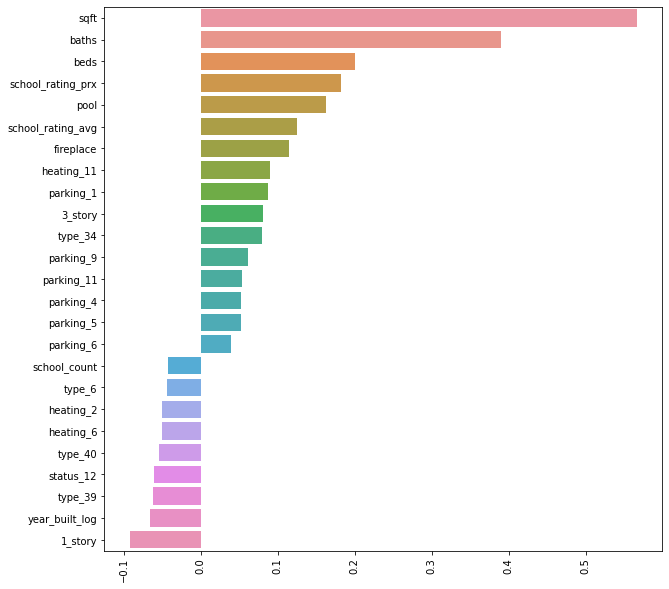

In [37]:
corr_matrix = data[np.append(col_names, 'target')].corr() # корреляционная матрица признаков
corr_matrix.drop(labels=['target'], inplace=True, axis=0)
# строим столбчатую диаграмму для коэффициентов корреляции
fig = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
bar1 = sns.barplot(
             y = list(corr_matrix['target'].sort_values(ascending=False).keys()),
             x = list(corr_matrix['target'].sort_values(ascending=False)),
             orient='h'
            )
bar1.tick_params(axis='x', rotation=90);

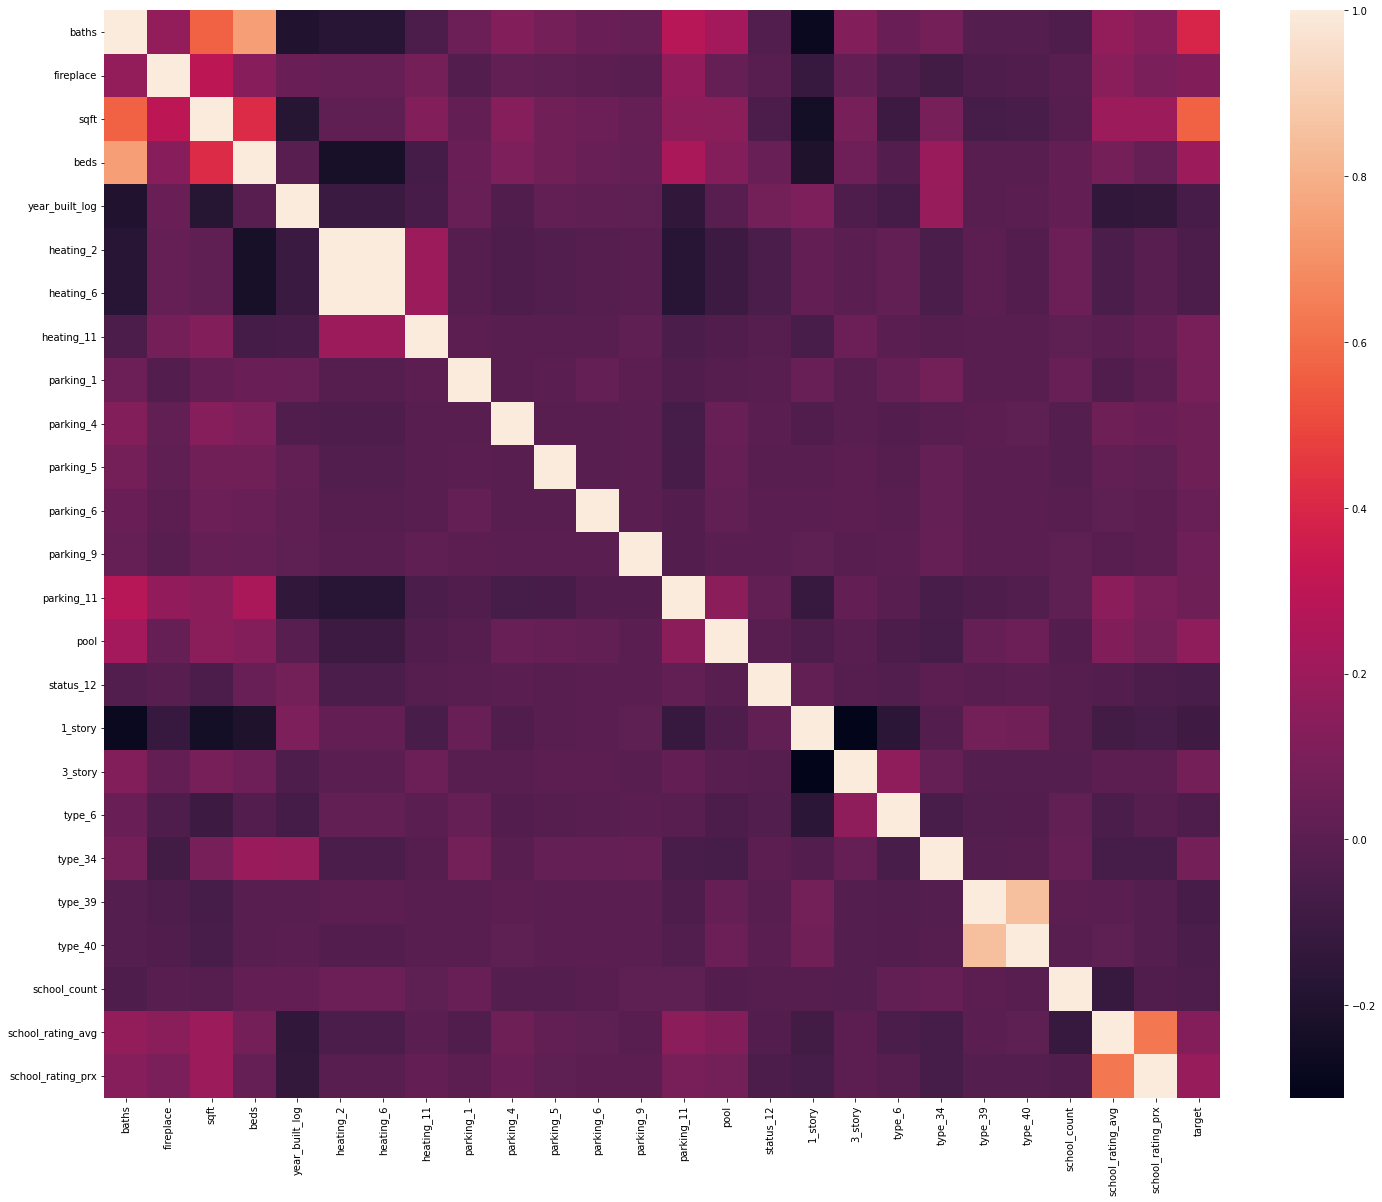

In [38]:
# строим тепловую карту для матрицы
fig = plt.subplots(nrows=1, ncols=1, figsize=(25,20))
heatmap = sns.heatmap(corr_matrix)

In [39]:
# отбрасываем ненужные признаки
X_train = X_train[col_names]
X_test = X_test[col_names]

In [40]:
# делим признаки на бинарные и небинарные
a = X_train.describe().loc['max']
binary_columns = list(a[a==1].keys())
nonbinary_columns = list(a[a>1].keys())
nonbinary_columns

['baths',
 'fireplace',
 'sqft',
 'beds',
 'year_built_log',
 'school_count',
 'school_rating_avg',
 'school_rating_prx']

Нормализуем и стандартизируем небинарные признаки

In [41]:
#Инициализируем стандартизатор MinMaxScaler
scaler = preprocessing.MinMaxScaler()
#Подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train[nonbinary_columns])
#Производим стандартизацию тренировочной выборки
X_train_nb_mm = scaler.transform(X_train[nonbinary_columns])
#Производим стандартизацию тестовой выборки
X_test_nb_mm = scaler.transform(X_test[nonbinary_columns])
#Производим стандартизацию тестовой выборки
X_valid_nb_mm = scaler.transform(X_valid[nonbinary_columns])

#Инициализируем стандартизатор StandardScaler
scaler = preprocessing.StandardScaler()
#Подгоняем параметры стандартизатора (вычисляем среднее и СКО)
scaler.fit(X_train_nb_mm)
#Производим стандартизацию тренировочной выборки
X_train_nb_scaled = scaler.transform(X_train_nb_mm)
#Производим стандартизацию тестовой выборки
X_test_nb_scaled = scaler.transform(X_test_nb_mm)
#Производим стандартизацию тестовой выборки
X_valid_nb_scaled = scaler.transform(X_valid_nb_mm)

# соединяем с бинарными признаками
X_train_scaled = np.concatenate((np.array(X_train[binary_columns]), X_train_nb_scaled), axis=1)
X_test_scaled = np.concatenate((np.array(X_test[binary_columns]), X_test_nb_scaled), axis=1)
X_valid_scaled = np.concatenate((np.array(X_valid[binary_columns]), X_valid_nb_scaled), axis=1)
#
X_train_scaled = pd.DataFrame(X_train_scaled, columns=binary_columns+nonbinary_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=binary_columns+nonbinary_columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled, columns=binary_columns+nonbinary_columns)

Оценим изменение признаков

In [42]:
"""
#Создаём генератор полиномиальных признаков
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
#Генерируем полиномиальные признаки для тренировочной выборки
X_train_scaled_poly = poly.transform(X_train_scaled)
#Генерируем полиномиальные признаки для тестовой выборки
X_test_scaled_poly = poly.transform(X_test_scaled)
#Выводим результирующие размерности таблиц
print(X_train_scaled_poly.shape)
print(X_test_scaled_poly.shape)
"""

'\n#Создаём генератор полиномиальных признаков\npoly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)\npoly.fit(X_train_scaled)\n#Генерируем полиномиальные признаки для тренировочной выборки\nX_train_scaled_poly = poly.transform(X_train_scaled)\n#Генерируем полиномиальные признаки для тестовой выборки\nX_test_scaled_poly = poly.transform(X_test_scaled)\n#Выводим результирующие размерности таблиц\nprint(X_train_scaled_poly.shape)\nprint(X_test_scaled_poly.shape)\n'

In [43]:
"""
#Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge(alpha=5)
#Обучаем модель
ridge_lr_poly.fit(X_train_scaled_poly, y_train)
#Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)
#Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)
#Рассчитываем MAE
print('MAE score: {:.0f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict_poly)))
#Рассчитываем MAPE
print('MAPE score: {:.0f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict_poly) * 100))
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))
"""

'\n#Создаём объект класса линейной регрессии с L2-регуляризацией\nridge_lr_poly = linear_model.Ridge(alpha=5)\n#Обучаем модель\nridge_lr_poly.fit(X_train_scaled_poly, y_train)\n#Делаем предсказание для тренировочной выборки\ny_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)\n#Делаем предсказание для тестовой выборки\ny_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)\n#Рассчитываем MAE\nprint(\'MAE score: {:.0f} $\'.format(metrics.mean_absolute_error(y_test, y_test_predict_poly)))\n#Рассчитываем MAPE\nprint(\'MAPE score: {:.0f} %\'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict_poly) * 100))\n#Рассчитываем коэффициент детерминации для двух выборок\nprint("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_train_predict_poly)))\nprint("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict_poly)))\n'

Отбор признаков, нормализация и применение полиномиальной регрессии дали слабый эффект и не привели к существенному улучшению метрики

Попробуем использовать дерево решений. Подберем оптимальную глубину древа

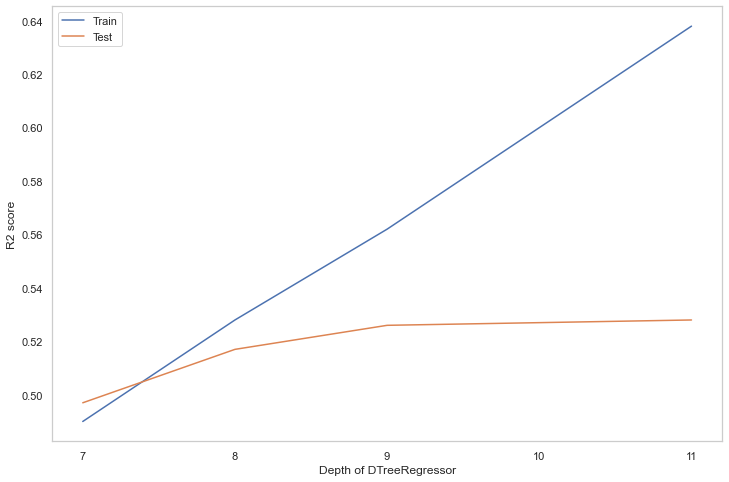

In [19]:
"""
max_depths = range(7,12)
train_score = []
test_score = []
for n in max_depths:
    dt = DecisionTreeRegressor(random_state = 42, max_depth=n)
    dt.fit(X_train_scaled, y_train)
    y_train_pred = dt.predict(X_train_scaled)
    y_test_pred = dt.predict(X_test_scaled)
    train_score.append(round(metrics.r2_score(y_train, y_train_pred),3))
    test_score.append(round(metrics.r2_score(y_test, y_test_pred),3))

fig,ax = plt.subplots(figsize=(12,8))
sns.lineplot(x=max_depths, y=train_score, label='Train')
sns.lineplot(x=max_depths, y=test_score, label='Test')
ax.set_xlabel('Depth of DTreeRegressor')
ax.set_ylabel('R2 score')
ax.set_xticks(max_depths)
ax.grid()
"""

In [20]:
"""
dt = DecisionTreeRegressor(random_state = 42, max_depth=12)
dt.fit(X_train_scaled, y_train)

#Предсказываем цену тестовой выборки
y_predict_train = dt.predict(X_train_scaled)
y_test_predict = dt.predict(X_test_scaled)
#Рассчитываем MAE
print('MAE score: {:.0f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
#Рассчитываем MAPE
print('MAPE score: {:.0f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100))
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_predict_train)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))
"""

MAE score: 243111 $
MAPE score: 67 %
Train R^2: 0.679
Test R^2: 0.526


Улучшений метрик не наблюдается

# Применяем ансамблевые методы

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import roc_auc_score

In [103]:
#Создаем объект класса случайный лес
rf = RandomForestRegressor(
    n_estimators = 100,
    max_depth = 12,
    criterion = 'squared_error',
    min_samples_leaf = 2,
    random_state = 42
    )

#Обучаем модель
rf.fit(X_train_scaled, y_train)
#Предсказываем результат и Выводим значения метрик
y_train_predict = rf.predict(X_train_scaled)
y_test_predict = rf.predict(X_test_scaled)
#Рассчитываем MAE
print('MAE score: {:.0f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
#Рассчитываем MAPE
print('MAPE score: {:.0f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100))
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_predict_train)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))

MAE score: 228132 $
MAPE score: 65 %
Train R^2: 0.432
Test R^2: 0.628


In [23]:
from sklearn.ensemble import GradientBoostingRegressor

In [27]:
# Градиентный бустинг
gb = GradientBoostingRegressor(
    learning_rate=0.1, #темп обучения
    n_estimators=160, #число деревьев
    max_depth=11, #максимальная глубина дерева
    min_samples_leaf = 5,
    random_state=42 #генератор случайных чисел
)
gb.fit(X_train_scaled, y_train)
#Предсказываем результат и Выводим значения метрики 
y_train_predict = gb.predict(X_train_scaled)
y_test_predict = gb.predict(X_test_scaled)
#Рассчитываем MAE
print('MAE score: {:.0f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
#Рассчитываем MAPE
print('MAPE score: {:.0f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict) * 100))
#Рассчитываем коэффициент детерминации для двух выборок
print("Train R^2: {:.3f}".format(metrics.r2_score(y_train, y_predict_train)))
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_test_predict)))

MAE score: 220641 $
MAPE score: 58 %
Train R^2: 0.446
Test R^2: 0.628


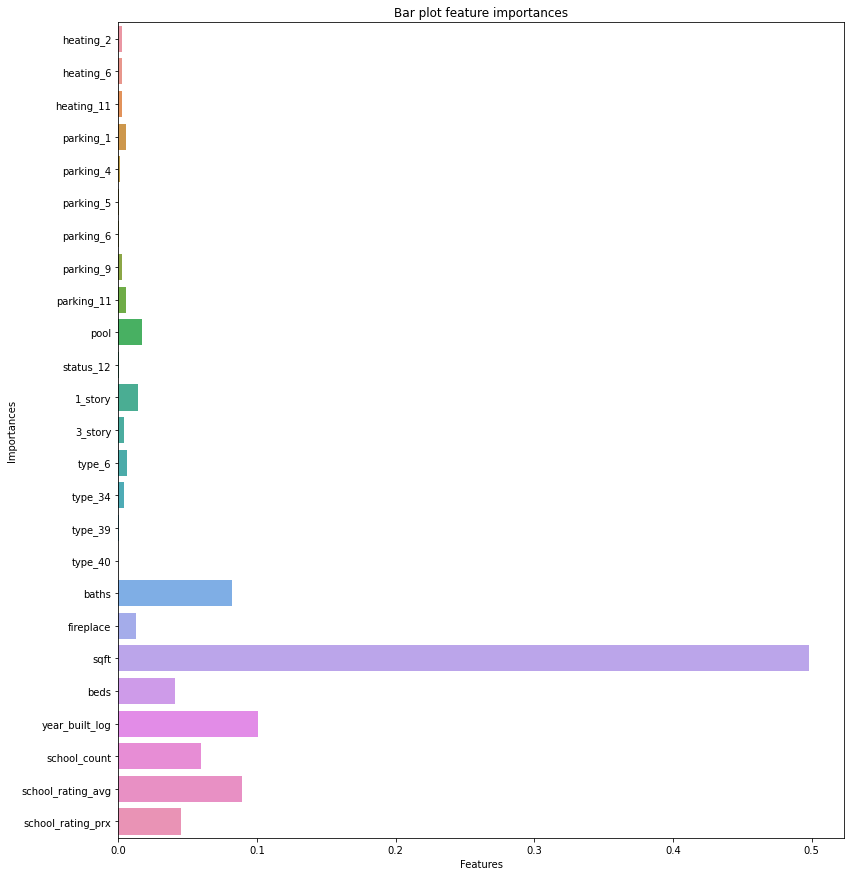

In [28]:
# ваш код здесь
fig, ax = plt.subplots(figsize=(13, 15)) #фигура + координатная плоскость
feature = X_train_scaled.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(y=feature, x=feature_importances, ax=ax, orient='h');
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

In [50]:
feature

Index(['heating_2', 'heating_6', 'heating_11', 'parking_1', 'parking_4',
       'parking_5', 'parking_6', 'parking_9', 'parking_11', 'pool',
       'status_12', '1_story', '3_story', 'type_6', 'type_34', 'type_39',
       'type_40', 'baths', 'fireplace', 'sqft', 'beds', 'year_built_log',
       'school_count', 'school_rating_avg', 'school_rating_prx'],
      dtype='object')

In [ ]:
np.concatenate(np.array(feature).reshape()

In [29]:
feature_importances

array([2.79546550e-03, 2.64566884e-03, 2.74558179e-03, 5.64963807e-03,
       1.25885430e-03, 1.80593400e-04, 2.96204046e-04, 2.92443968e-03,
       5.80976182e-03, 1.73570686e-02, 6.66296449e-04, 1.42525037e-02,
       4.42397515e-03, 5.97087812e-03, 4.14132350e-03, 6.84932739e-04,
       3.75679074e-05, 8.20057604e-02, 1.27762168e-02, 4.98170871e-01,
       4.07918086e-02, 1.00922586e-01, 5.94454755e-02, 8.88471640e-02,
       4.51993642e-02])

# XGBoost

In [54]:
from xgboost import XGBRegressor

In [55]:
xgb = XGBRegressor(
        objective='reg:squarederror'
)
xgb.fit(X_train_scaled, np.array(y_train))
y_test_predict = xgb.predict(X_test_scaled)
#Рассчитываем MAE
print('MAE score: {:.0f} $'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
print(f'Качество предсказания r2_score {round(metrics.r2_score(y_test, y_test_predict),3)}')

MAE score: 235281 $
Качество предсказания r2_score 0.591


In [113]:
import sklearn

In [114]:
sklearn.__version__

'1.2.2'

# Стекинг

In [44]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

In [52]:
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dt',  DecisionTreeRegressor(random_state=42))
]

#Создаем объект класса стекинг
reg = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=10,
                                          random_state=42)
)
#Обучаем модель
reg.fit(X_train_scaled, y_train)
y_pred_stack = reg.predict(X_test_scaled)
#Рассчитываем MAE
print('MAE score: {:.0f} $'.format(metrics.mean_absolute_error(y_test, y_pred_stack)))
#Рассчитываем MAPE
print('MAPE score: {:.0f} %'.format(metrics.mean_absolute_percentage_error(y_test, y_pred_stack) * 100))
#Рассчитываем коэффициент детерминации для двух выборок
print("Test R^2: {:.3f}".format(metrics.r2_score(y_test, y_pred_stack)))

MAE score: 284294 $
MAPE score: 81 %
Test R^2: 0.362


Не удалось подобрать оптимальную стекинг-схему, дающую сколько нибудь приличный результат

# Оптимизация гиперпараметров

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Сериализация модели

In [ ]:
regressor = gb

In [ ]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('model.pkl', 'wb') as output:
    pickle.dump(regressor, output)

In [3]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.0.4


In [4]:
optuna.visualization.is_available()

True